# **Import Libraries**

In [91]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

# **Feature Engineering**

### **Import Datsets**

In [92]:
clean_data = pd.read_csv('D:/LHL/repo2/PowerCo-Custumer-Churn/PowerCo-Custumer-Churn/Data/cleaned_data.csv')
clean_data["date_activ"] = pd.to_datetime(clean_data["date_activ"], format='%Y-%m-%d')
clean_data["date_end"] = pd.to_datetime(clean_data["date_end"], format='%Y-%m-%d')
clean_data["date_modif_prod"] = pd.to_datetime(clean_data["date_modif_prod"], format='%Y-%m-%d')
clean_data["date_renewal"] = pd.to_datetime(clean_data["date_renewal"], format='%Y-%m-%d')
clean_data.head()



,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,avg_var_offpeak,avg_var_peak,avg_var_midpeak,avg_fix_offpeak,avg_fix_peak,avg_fix_midpeak,date_activ_year,date_end_year,date_modif_prod_year,date_renewal_year
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,0.124787,0.100749,0.066530,40.942265,22.352010,14.901340,2013,2016,2015,2015
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.149609,0.007124,0.000000,44.311375,0.000000,0.000000,2009,2016,2009,2015
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.170512,0.088421,0.000000,44.385450,0.000000,0.000000,2010,2016,2010,2015
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.151210,0.000000,0.000000,44.400265,0.000000,0.000000,2010,2016,2010,2015
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.124174,0.103638,0.072865,40.688156,24.412893,16.275263,2010,2016,2010,2015


## **1. Monthly prices differences**

#### **Difference between December vs. January off-peak prices**
- This feature captures the monthly fluctuations in off-peak prices, providing insight into how price changes affect customer behavior over time. By calculating the difference in off-peak prices from month to month, we can assess the degree of price volatility experienced by each customer throughout the year. This variation serves as a proxy for pricing pressure, helping to identify customers who may be more sensitive to cost changes and, consequently, more likely to churn

In [93]:
# Step 1: Import price data
price_data = pd.read_csv('D:/LHL/repo2/PowerCo-Custumer-Churn/PowerCo-Custumer-Churn/Data/price_data.csv')
price_data['price_date'] = pd.to_datetime(price_data['price_date'], format='%Y-%m-%d')

In [94]:
# Step 2: Calculate Dec vs Jan Differences 

# Ensure price_date is datetime
price_data['price_date'] = pd.to_datetime(price_data['price_date'])

# Sort before taking first/last
monthly_price_by_id = price_data.sort_values(by=['id', 'price_date']).groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean',
    'price_off_peak_fix': 'mean'
}).reset_index()

# get first and last records per ID
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Merge and compute differences
diff = pd.merge(
    dec_prices.rename(columns={
        'price_off_peak_var': 'dec_e1',
        'price_off_peak_fix': 'dec_p2'
    }),
    jan_prices.drop(columns='price_date'),
    on='id'
)

diff['offpeak_diff_dec_january_energy'] = diff['dec_e1'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_p2'] - diff['price_off_peak_fix']

# Retain only the two new features + id
diff = diff[['id', 'offpeak_diff_dec_january_energy', 'offpeak_diff_dec_january_power']]


# === STEP 3: Merge Everything with client_df ===

client_price_df = clean_data.merge(diff, on='id', how='left')
print("Succefully merged client data with price differences.")

Succefully merged client data with price differences.


- Sanity check ensuring that first() and last() are truly Jan and Dec.

In [95]:
monthly_price_by_id.groupby('id')['price_date'].agg(['min', 'max']).sample(5)


,min,max
id,,
c1359e1d51082033cdfb6008108f05a2,2015-01-01,2015-12-01
eccebfe398b70a2eb8b45c6efc1a3efa,2015-01-01,2015-12-01
0a43f2f6d9f311ee5e64c135b049e0a3,2015-01-01,2015-12-01
9d64dba68e022dce29143ca3089071fc,2015-01-01,2015-12-01
e4e183646f7fd7ab5875eab449541aa4,2015-01-01,2015-12-01


#### **Average price changes across individual periods**
- I thought that calculating the maximum price change between months and time periods would be a good feature to create because I was trying to think from the perspective of a PowerCo client. As a Utilities customer, there is nothing more annoying than sudden price changes between months, and a large increase in prices within a short time span would be an influencing factor in causing me to look at other utilities providers for a better deal. Since we are trying to predict churn for this use case, I thought this would be an interesting feature to include.

In [96]:
# Calculate the mean difference between consecutive periods
client_price_df['off_peak_peak_var_mean_diff'] = client_price_df['avg_var_offpeak'] - client_price_df['avg_var_peak']
client_price_df['peak_mid_peak_var_mean_diff'] = client_price_df['avg_var_peak'] - client_price_df['avg_var_midpeak']
client_price_df['off_peak_mid_peak_var_mean_diff'] = client_price_df['avg_var_offpeak'] - client_price_df['avg_var_midpeak']
client_price_df['off_peak_peak_fix_mean_diff'] = client_price_df['avg_fix_offpeak'] - client_price_df['avg_fix_peak']
client_price_df['peak_mid_peak_fix_mean_diff'] = client_price_df['avg_fix_peak'] - client_price_df['avg_fix_midpeak']
client_price_df['off_peak_mid_peak_fix_mean_diff'] = client_price_df['avg_fix_offpeak'] - client_price_df['avg_fix_midpeak']

### **2. Temporal Features (Customer Lifecycle)**
- These features capture contract dynamics and customer tenure, which often correlate with churn.

#### **Tenure Days**
- Days since contract started: date_end - date_activ

In [97]:
# Days since contract started: date_end - date_activ
def days_since_contract_started(row):
    if row['date_end'] == 'NULL':
        return 0
    else:
        date_end = pd.to_datetime(row['date_end'])
        date_activation = pd.to_datetime(row['date_activ'])
        return (date_end - date_activation).days

# Apply to rows
client_price_df['tenure_days'] = client_price_df.apply(days_since_contract_started, axis=1)
client_price_df['tenure_days'].head()

0    1096
1    2566
2    2192
3    2192
4    2245
Name: tenure_days, dtype: int64

#### **Days until renewal**
- How soon the customer is due for renewal: date_renewal - latest avaliable date in the dataset
- Step 1: Find the Latest available price date in the Dataset and treat as the "current" date in the dataset’s context

In [98]:
# Identify the most recent date in the dataset
latest_date = pd.to_datetime(price_data['price_date'].max())
print("Latest available date in the dataset:", latest_date)


Latest available date in the dataset: 2015-12-01 00:00:00


In [99]:
# How soon the customer is due for renewal
def days_until_renewal(row):
    if row['date_renewal'] == 'NULL':
        return 0
    else:
        date_renewal = pd.to_datetime(row['date_renewal'])
        return (date_renewal - latest_date).days

# Apply to rows
client_price_df['days_until_renewal'] = client_price_df.apply(days_until_renewal, axis=1)
client_price_df['days_until_renewal'].head()

0   -161
1    -92
2   -228
3   -245
4   -267
Name: days_until_renewal, dtype: int64

How to Interpret Negative Values
- Negative days_until_renewal → Customer’s renewal date was in the past (i.e., their contract should have already been renewed or ended).

- Positive days_until_renewal → Customer still had time left before renewal.

#### **Transforming dates into months**

- months_activ = Number of months active until reference date (latest_date)
- months_to_end = Number of months of the contract left until reference date (latest_date)
- months_modif_prod = Number of months since last modification until reference date (latest_date)
- months_renewal = Number of months since last renewal until reference date (latest_date)

Dates as a datetime object are not useful for a predictive model, so we needed to use the datetimes to create some other features that may hold some predictive power.

In [100]:
def convert_months(latest_date, client_price_df, column):
    """
    Input a column with timedeltas and return months
    """
    time_delta = latest_date - client_price_df[column]
    months = (time_delta / np.timedelta64(1, 'M')).astype(int)
    return months

# Convert date columns to months since latest date
# Create columns
client_price_df['months_activ'] = convert_months(latest_date, client_price_df, 'date_activ')
client_price_df['months_to_end'] = -convert_months(latest_date, client_price_df, 'date_end')
client_price_df['months_modif_prod'] = convert_months(latest_date, client_price_df, 'date_modif_prod')
client_price_df['months_renewal'] = convert_months(latest_date, client_price_df, 'date_renewal')

#### **Days since last modification**
- Time since product last changed: latest_date - date_modif_prod

In [101]:
# Time since product last changed:
def days_since_product_changed(row):
    if row['date_modif_prod'] == 'NULL':
        return 0
    else:
        date_modif_prod = pd.to_datetime(row['date_modif_prod'])
        return (latest_date - date_modif_prod).days
# Apply to rows
client_price_df['days_since_product_changed'] = client_price_df.apply(days_since_product_changed, axis=1)
client_price_df['days_since_product_changed'].head()

0      30
1    2293
2    2055
3    2072
4    2148
Name: days_since_product_changed, dtype: int64

#### **Time from Renewal to Contract End**
- How long contarct ended after renewal

In [102]:
# How long until the contract ends after renewal:
def days_until_contract_end(row):
    if row['date_end'] == 'NULL':
        return 0
    else:
        date_end = pd.to_datetime(row['date_end'])
        date_renewal = pd.to_datetime(row['date_renewal'])
        return (date_end - date_renewal).days
# Apply to rows
client_price_df['days_until_contract_end'] = client_price_df.apply(days_until_contract_end, axis=1)
client_price_df['days_until_contract_end'].head()

0    358
1    365
2    365
3    365
4    364
Name: days_until_contract_end, dtype: int64

#### **Time from last modification to renewal**


In [103]:
def calculate_modification_to_renewal_days(df, renewal_col='date_renewal', modif_col='date_modif_prod'):
    
    # Convert columns to datetime
    df[renewal_col] = pd.to_datetime(df[renewal_col], errors='coerce')
    df[modif_col] = pd.to_datetime(df[modif_col], errors='coerce')

    # Compute difference in days
    df['modification_to_renewal_days'] = (df[renewal_col] - df[modif_col]).dt.days

    # Check NaN values
    nan_count = df['modification_to_renewal_days'].isna().sum()

    return df, nan_count

# Example usage
client_price_df, nan_values = calculate_modification_to_renewal_days(client_price_df)
print(f"NaN values in 'modification_to_renewal_days': {nan_values}")
print(client_price_df[['modification_to_renewal_days']].head())


NaN values in 'modification_to_renewal_days': 0
   modification_to_renewal_days
0                          -131
1                          2201
2                          1827
3                          1827
4                          1881


#### **Recent Modification Before Renewal** 
- binary indicator: 1 if modification happened within 30 days before renewal

In [104]:
threshold = 30  # days
client_price_df['recent_modification_before_renewal'] = client_price_df['modification_to_renewal_days'].apply(
    lambda x: 1 if pd.notnull(x) and 0 <= x <= threshold else 0
)

client_price_df['recent_modification_before_renewal'].head()

0    0
1    0
2    0
3    0
4    0
Name: recent_modification_before_renewal, dtype: int64

## **2. Price & Margin Sensitivity**
- These features proxy for how much the customer pays and whether they might feel overcharged.

#### **Off peak Ratio**  
- average price of energy for the 1st period (off peak) / average price of power for the 1st period (off peak)

In [105]:
# avg_var_offpeak / avg_fix_offpeak
def avg_offpeak_ratio(row):
    if row['avg_var_offpeak'] == 0:
        return 0
    else:
        return row['avg_fix_offpeak'] / row['avg_var_offpeak']

# Apply to rows
client_price_df['avg_offpeak_ratio'] = client_price_df.apply(avg_offpeak_ratio, axis=1)
client_price_df['avg_offpeak_ratio'].head()

0    328.096982
1    296.181379
2    260.307410
3    293.632966
4    327.669616
Name: avg_offpeak_ratio, dtype: float64

#### **Forecast vs Actual_margin**
- Calculates forecast vs actual margin using forecasted off-peak & peak energy prices,meter rent,  and discount adjustments. Returns the difference between forecasted revenue (after discounts) and actual net margin

In [106]:
def forecast_accuracy(row):
    if any(pd.isna([row['forecast_price_energy_off_peak'], row['forecast_price_energy_peak'], row['forecast_discount_energy'], row['forecast_meter_rent_12m'], row['net_margin']])):
        return 0
    else:
        forecasted_cost = (row['forecast_price_energy_off_peak'] + row['forecast_price_energy_peak']) - row['forecast_discount_energy']  # Adjusting for discount
        expected_revenue = forecasted_cost + row['forecast_meter_rent_12m']  # Adding fixed meter rent
        return expected_revenue - row['net_margin']  # Difference between forecasted and actual profitability

# Apply the function
client_price_df['forecast_vs_actual_margin'] = client_price_df.apply(forecast_accuracy, axis=1)
# Display the first few rows of the new column
client_price_df['forecast_vs_actual_margin'].head()

0   -676.997377
1     -2.474289
2     32.373693
3     -5.483306
4     83.966915
Name: forecast_vs_actual_margin, dtype: float64

#### **Forecast Error Peak**
- The differences between forcasted energy and average energy consumption

In [107]:
# forecast_price_energy_peak - avg_var_peak
def forecast_vs_avg_peak(row):
    if row['forecast_price_energy_peak'] is None or row['avg_var_peak'] is None:
        return 0
    else:
        return row['forecast_price_energy_peak'] + row['forecast_price_energy_off_peak'] - row['avg_var_peak']

# Apply to rows
client_price_df['forecast_vs_avg_peak'] = client_price_df.apply(forecast_vs_avg_peak, axis=1)
client_price_df['forecast_vs_avg_peak'].head()

0    0.111874
1    0.138587
2    0.165272
3    0.146694
4    0.113277
Name: forecast_vs_avg_peak, dtype: float64

#### **Price Efficiency**
- Ratio of net margin on power subscription to subscribed power

In [108]:
# margin_net_pow_ele / pow_max
def margin_net_pow_ele_ratio(row):
    if row['pow_max'] == 0:
        return 0
    else:
        return row['margin_net_pow_ele'] / row['pow_max']
# Apply to rows
client_price_df['margin_net_pow_ele_ratio'] = client_price_df.apply(margin_net_pow_ele_ratio, axis=1)
client_price_df['margin_net_pow_ele_ratio'].head()

0    0.582845
1    1.186957
2    2.064088
3    2.289394
4    2.268182
Name: margin_net_pow_ele_ratio, dtype: float64

In [109]:
# avg_var_peak - avg_fix_peak (price volatility)
def avg_peak_volatility(row):
    if row['avg_var_peak'] == 0:
        return 0
    else:
        return row['avg_fix_peak'] - row['avg_var_peak']
# Apply to rows
client_price_df['avg_peak_volatility'] = client_price_df.apply(avg_peak_volatility, axis=1)
client_price_df['avg_peak_volatility'].head()

0    22.251261
1    -0.007124
2    -0.088421
3     0.000000
4    24.309255
Name: avg_peak_volatility, dtype: float64

## **3. Consumption Behavior**
- How customers use gas/electricity over time is a strong behavioral signal.

#### **Monthly Average Consumption**

In [110]:
# cons_12m / 12
def avg_monthly_consumption(row):
    if row['cons_12m'] is None:
        return 0
    else:
        return row['cons_12m'] / 12

# Apply to rows
client_price_df['avg_monthly_consumption'] = client_price_df.apply(avg_monthly_consumption, axis=1)
client_price_df['avg_monthly_consumption'].head()

0      0.000000
1    388.333333
2     45.333333
3    132.000000
4    368.750000
Name: avg_monthly_consumption, dtype: float64

#### **Consistency Ratio**
- How consistent do customers use the Electricity

In [111]:
# cons_last_month / monthly_avg_consumption
def consistency_ratio(row):
    if row['cons_last_month'] is None or row['avg_monthly_consumption'] == 0:
        return 0
    else:
        return row['cons_last_month'] / row['avg_monthly_consumption']

# Apply to rows
client_price_df['consistency_ratio'] = client_price_df.apply(consistency_ratio, axis=1)
client_price_df['consistency_ratio'].head()

0    0.000000
1    0.000000
2    0.000000
3    0.000000
4    1.426441
Name: consistency_ratio, dtype: float64

#### **Forecast Accuracy**
- Difference between the forcasted and past electricity consumption

In [112]:
# forecast_accuracy	
def forecast_accuracy(row):
    if row['forecast_cons_12m'] is None or row['cons_12m'] is None:
        return 0
    else:
        return row['forecast_cons_12m'] - row['cons_12m']
# Apply to rows
client_price_df['forecast_accuracy'] = client_price_df.apply(forecast_accuracy, axis=1)
client_price_df['forecast_accuracy'].head()

0       0.00
1   -4470.05
2    -496.04
3   -1343.96
4   -3979.25
Name: forecast_accuracy, dtype: float64

#### **Has declining consumption?**
- attempting to flag customers whose most recent month’s electricity use is substantially lower than their 12-month average

In [113]:
# has_declining_consumption	1 if cons_last_month < (monthly_avg_consumption * 0.8)
def has_declining_consumption(row):
    threshold = 0.8
    if row['cons_last_month'] is None or row['avg_monthly_consumption'] == 0:
        return 0
    else:
        return 1 if row['cons_last_month'] < (row['avg_monthly_consumption'] * threshold) else 0
    
# Apply to rows
client_price_df['has_declining_consumption'] = client_price_df.apply(has_declining_consumption, axis=1)
client_price_df['has_declining_consumption'].head()

0    0
1    1
2    1
3    1
4    0
Name: has_declining_consumption, dtype: int64

## **4. Engagement/Product Usage**
- More engaged customers are less likely to churn.

#### **Multiple Service User**
- Does the user have multiple services?

In [114]:
# multi_service_user: 1 if nb_prod_act > 1, else 0
def multi_service_user(row):
    return 1 if row['nb_prod_act'] > 1 else 0

# Apply to rows
client_price_df['multi_service_user'] = client_price_df.apply(multi_service_user, axis=1)
client_price_df['multi_service_user'].head()

0    1
1    0
2    0
3    0
4    0
Name: multi_service_user, dtype: int64

#### **High power user**
- Maximum power greater than the median?

In [115]:
client_price_df['pow_max'].describe()

count    14606.000000
mean        18.135136
std         13.534743
min          3.300000
25%         12.500000
50%         13.856000
75%         19.172500
max        320.000000
Name: pow_max, dtype: float64

- Using the 75th percentile as the threshold ensures that we capture true high-power users while minimizing the impact of outliers. Since the data is right-skewed, this approach is more robust than the mean, which is easily influenced by extreme values, and more selective than the median, which would label half of the users as high-power.

In [116]:
# 1 if pow_max > threshold (75th percentile), else 0 
def high_power_user(row):
    threshold = client_price_df['pow_max'].quantile(0.75)
    return 1 if row['pow_max'] > threshold else 0
# Apply to rows
client_price_df['high_power_user'] = client_price_df.apply(high_power_user, axis=1)
client_price_df['high_power_user'].head()

0    1
1    0
2    0
3    0
4    1
Name: high_power_user, dtype: int64

## **5.Price-to-Usage Alignment**
- These test whether high payers are also high consumers — or overcharged.

### **Price per Kwh**

In [117]:
# price_per_kwh	net_margin / cons_12m
def price_per_kwh(row):
    if row['cons_12m'] == 0:
        return 0
    else:
        return row['net_margin'] / row['cons_12m']

# Apply to rows
client_price_df['price_per_kwh'] = client_price_df.apply(price_per_kwh, axis=1) 
client_price_df['price_per_kwh'].head()

0    0.000000
1    0.004054
2    0.012132
3    0.016073
4    0.010843
Name: price_per_kwh, dtype: float64

#### **Power cost ratio**

In [118]:
# Power_cost_ratio
def power_cost_ratio(row):
    if row['net_margin'] == 0:
        return 0
    else:
        return row['pow_max'] / row['net_margin']

# Apply to rows
client_price_df['power_cost_ratio'] = client_price_df.apply(power_cost_ratio, axis=1)
client_price_df['power_cost_ratio'].head()

0    0.064284
1    0.730545
2    2.099394
3    0.518460
4    0.412672
Name: power_cost_ratio, dtype: float64

#### **Unit cost deviation**

In [119]:
# unit_cost_deviation	forecast_price_energy_peak / cons_last_month
def unit_cost_deviation(row):
    if row['cons_last_month'] == 0:
        return 0
    else:
        return row['forecast_price_energy_peak'] / row['cons_last_month']
# Apply to rows
client_price_df['unit_cost_deviation'] = client_price_df.apply(unit_cost_deviation, axis=1)
client_price_df['unit_cost_deviation'].head()

0    0.00000
1    0.00000
2    0.00000
3    0.00000
4    0.00019
Name: unit_cost_deviation, dtype: float64

# **Vizualization**

In [120]:
cols = [
    'margin_net_pow_ele', 'margin_gross_pow_ele', 'num_years_antig', 'margin_net_pow_ele_ratio',
    'date_modif_prod_year', 'avg_peak_volatility', 'avg_fix_peak', 'avg_var_midpeak', 'forecast_accuracy',
    'avg_fix_midpeak', 'forecast_meter_rent_12m', 'net_margin', 'avg_offpeak_ratio', 'high_power_user',
    'price_per_kwh', 'pow_max', 'unit_cost_deviation', 'avg_var_peak', 'forecast_price_energy_peak',
    'forecast_discount_energy', 'avg_fix_offpeak', 'nb_prod_act', 'forecast_price_pow_off_peak',
    'forecast_cons_12m', 'has_declining_consumption', 'forecast_price_energy_off_peak', 'consistency_ratio',
    'power_cost_ratio', 'forecast_vs_avg_peak', 'avg_var_offpeak','offpeak_diff_dec_january_power',
    'cons_12m', 'cons_gas_12m', 'cons_last_month', 'tenure_days', 'days_until_renewal',
    'days_since_product_changed', 'days_until_contract_end', 'modification_to_renewal_days',
    'recent_modification_before_renewal', 'multi_service_user', 'forecast_vs_actual_margin',
    'avg_monthly_consumption', 'has_gas','forecast_cons_year', 'imp_cons', 'offpeak_diff_dec_january_energy',
    'off_peak_peak_var_mean_diff', 'peak_mid_peak_var_mean_diff', 'off_peak_mid_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff', 'peak_mid_peak_fix_mean_diff', 'off_peak_mid_peak_fix_mean_diff',
    'months_activ', 'months_to_end', 'months_modif_prod', 'months_renewal'
]

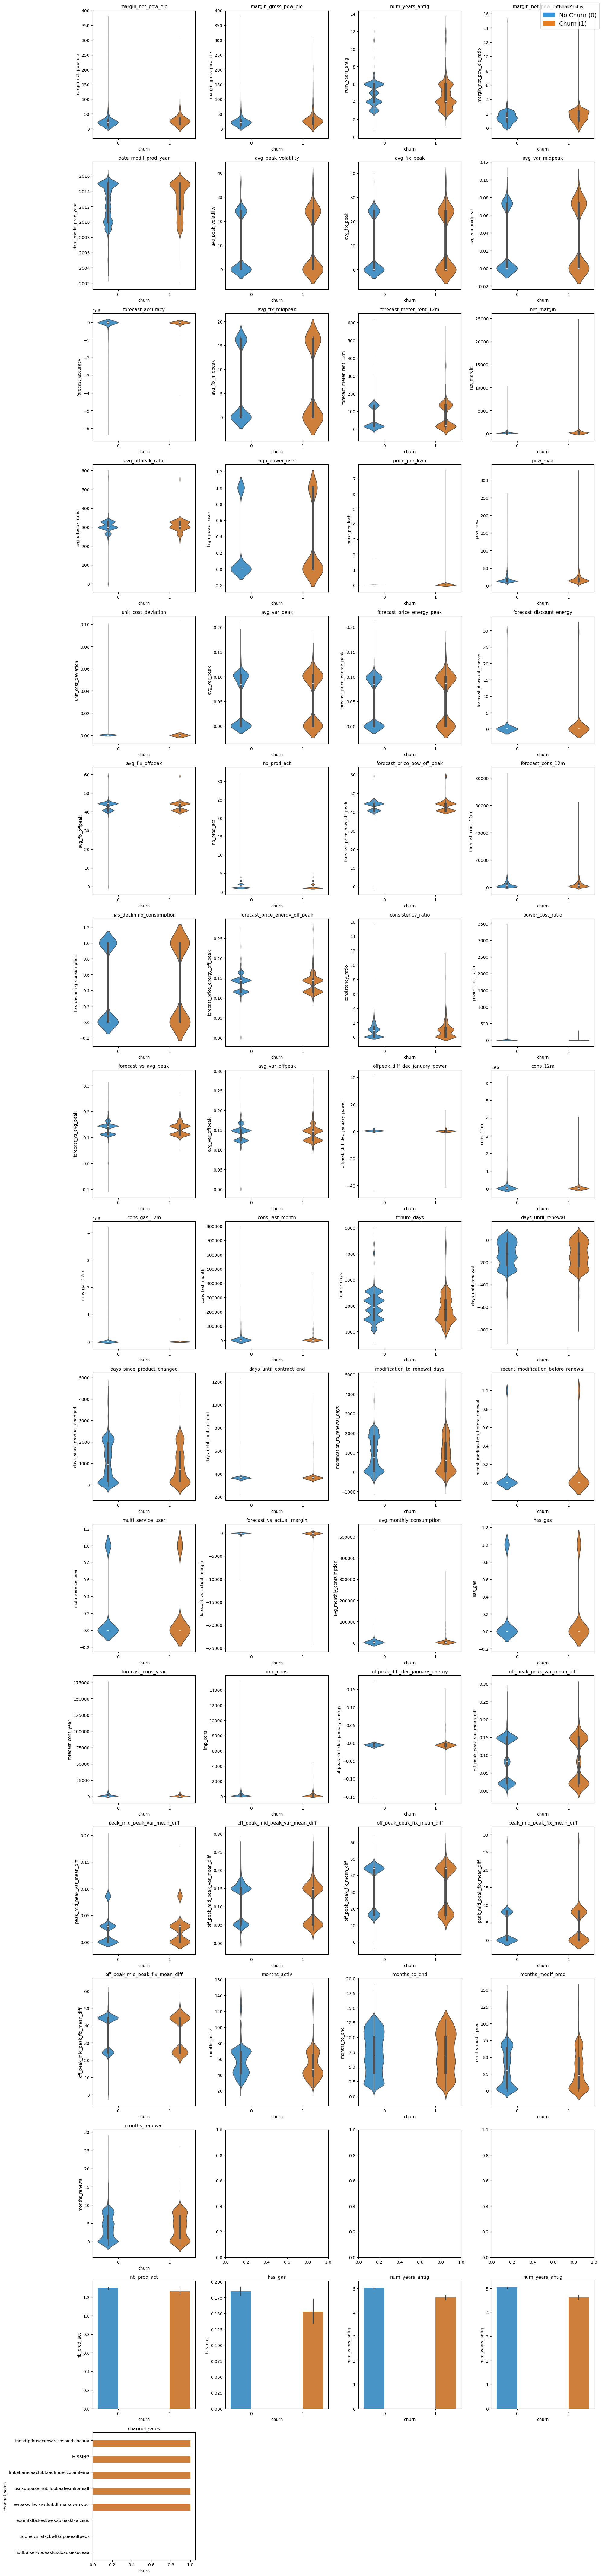

In [121]:
# Define a color palette for churn
churn_palette = {0: "#3498db", 1: "#e67e22"}

# Set number of columns and compute number of rows needed for the features
n_cols = 4
n_rows = int((len(cols) + n_cols - 1) // n_cols)

fig, ax = plt.subplots(n_rows + 3, n_cols, figsize=(20, 5 * (n_rows + 3)))

# Plot violin plots for each feature
for i, col in enumerate(cols):
    row, col_index = divmod(i, n_cols)
    sns.violinplot(
        data=client_price_df, y=col, x='churn', ax=ax[row, col_index],
        hue='churn', palette=churn_palette, dodge=True, legend=False
    )
    ax[row, col_index].set_title(f'{col}', fontsize=11)
    ax[row, col_index].get_legend().remove() if ax[row, col_index].get_legend() else None

# Plot barplots with the same palette
sns.barplot(client_price_df, x='churn', y='nb_prod_act', ax=ax[n_rows, 0], hue='churn', palette=churn_palette, dodge=True, legend=False)
ax[n_rows, 0].set_title(f'nb_prod_act', fontsize=11)
sns.barplot(client_price_df, x='churn', y='has_gas', ax=ax[n_rows, 1], hue='churn', palette=churn_palette, dodge=True, legend=False)
ax[n_rows, 1].set_title(f'has_gas', fontsize=11)
sns.barplot(client_price_df, x='churn', y='num_years_antig', ax=ax[n_rows, 2], hue='churn', palette=churn_palette, dodge=True, legend=False)
ax[n_rows, 2].set_title(f'num_years_antig', fontsize=11)
sns.barplot(client_price_df, x='churn', y='num_years_antig', ax=ax[n_rows, 3], hue='churn', palette=churn_palette, dodge=True, legend=False)
ax[n_rows, 3].set_title(f'num_years_antig', fontsize=11)
sns.barplot(client_price_df, x='churn', y='channel_sales', ax=ax[n_rows + 1, 0], hue='churn', palette=churn_palette, dodge=True, legend=False)
ax[n_rows + 1, 0].set_title(f'channel_sales', fontsize=11)

# Churn count barplot (manual colors)
churn_counts = client_price_df['churn'].value_counts().sort_index()
ax[n_rows + 1, 1].bar(churn_counts.index.astype(str), churn_counts.values, color=[churn_palette[k] for k in churn_counts.index])
ax[n_rows + 1, 1].set_title(f'churn', fontsize=11)

# Add barplot for recent_modification_before_renewal
sns.barplot(client_price_df, x='churn', y='recent_modification_before_renewal', ax=ax[n_rows + 1, 2], hue='churn', palette=churn_palette, dodge=True, legend=False)
ax[n_rows + 1, 2].set_title(f'recent_modification_before_renewal', fontsize=11)
sns.barplot(client_price_df, x='churn', y='has_declining_consumption', ax=ax[n_rows + 1, 3], hue='churn', palette=churn_palette, dodge=True, legend=False)
ax[n_rows + 1, 3].set_title(f'has_declining_consumption', fontsize=11)

# Hide unused axes
total_plots = len(cols) + 8
for j in range(total_plots, ax.size):
    ax.flat[j].set_visible(False)

# Create a single legend for churn colors
handles = [
    mpatches.Patch(color=churn_palette[0], label='No Churn (0)'),
    mpatches.Patch(color=churn_palette[1], label='Churn (1)')
]
fig.legend(handles=handles, loc='upper right', fontsize=14, title='Churn Status')

plt.tight_layout()
plt.show()

# **Correlation With Target**
- Identify relationships between features and the target (churn)

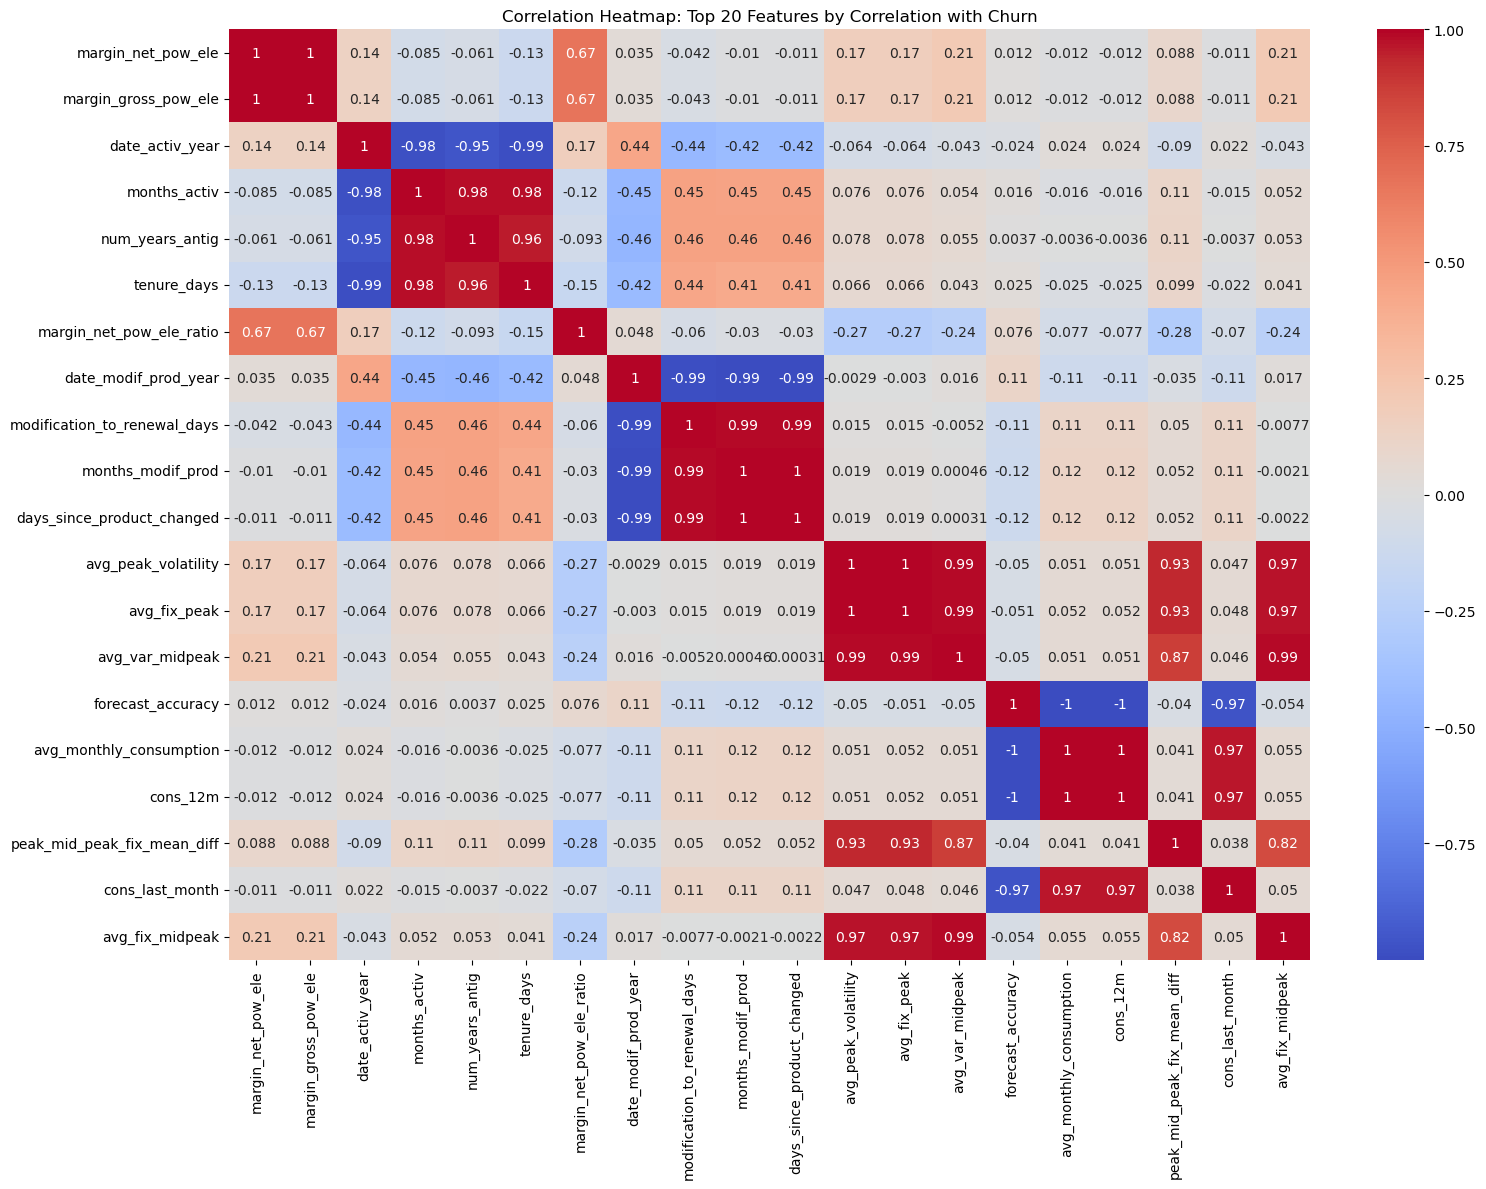

In [122]:
# Compute correlation of all numeric columns with churn
corr_with_target = client_price_df.corr(numeric_only=True)['churn']

top20 = corr_with_target.abs().sort_values(ascending=False).index[1:21]  # skip 'churn' itself
plt.figure(figsize=(16, 12))
sns.heatmap(client_price_df[top20].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap: Top 20 Features by Correlation with Churn")
plt.tight_layout()
plt.show()

- Multicollinearity: Some features are extremely correlated with each other (e.g., avg_peak_volatility, avg_fix_peak, and avg_var_midpeak), as seen by the dark red squares off the diagonal. This means they capture very similar information, which can confuse models and reduce interpretability.
Temporal Redundancy: Features like date_activ_year and num_years_antig are almost perfectly negatively correlated, meaning they are essentially inverses of each other.
Margin Features: margin_net_pow_ele, margin_gross_pow_ele, and margin_net_pow_ele_ratio are highly correlated, reflecting similar aspects of customer profitability.
Consumption Features: avg_monthly_consumption, cons_12m, and cons_last_month are also highly correlated, as they are derived from similar underlying data.

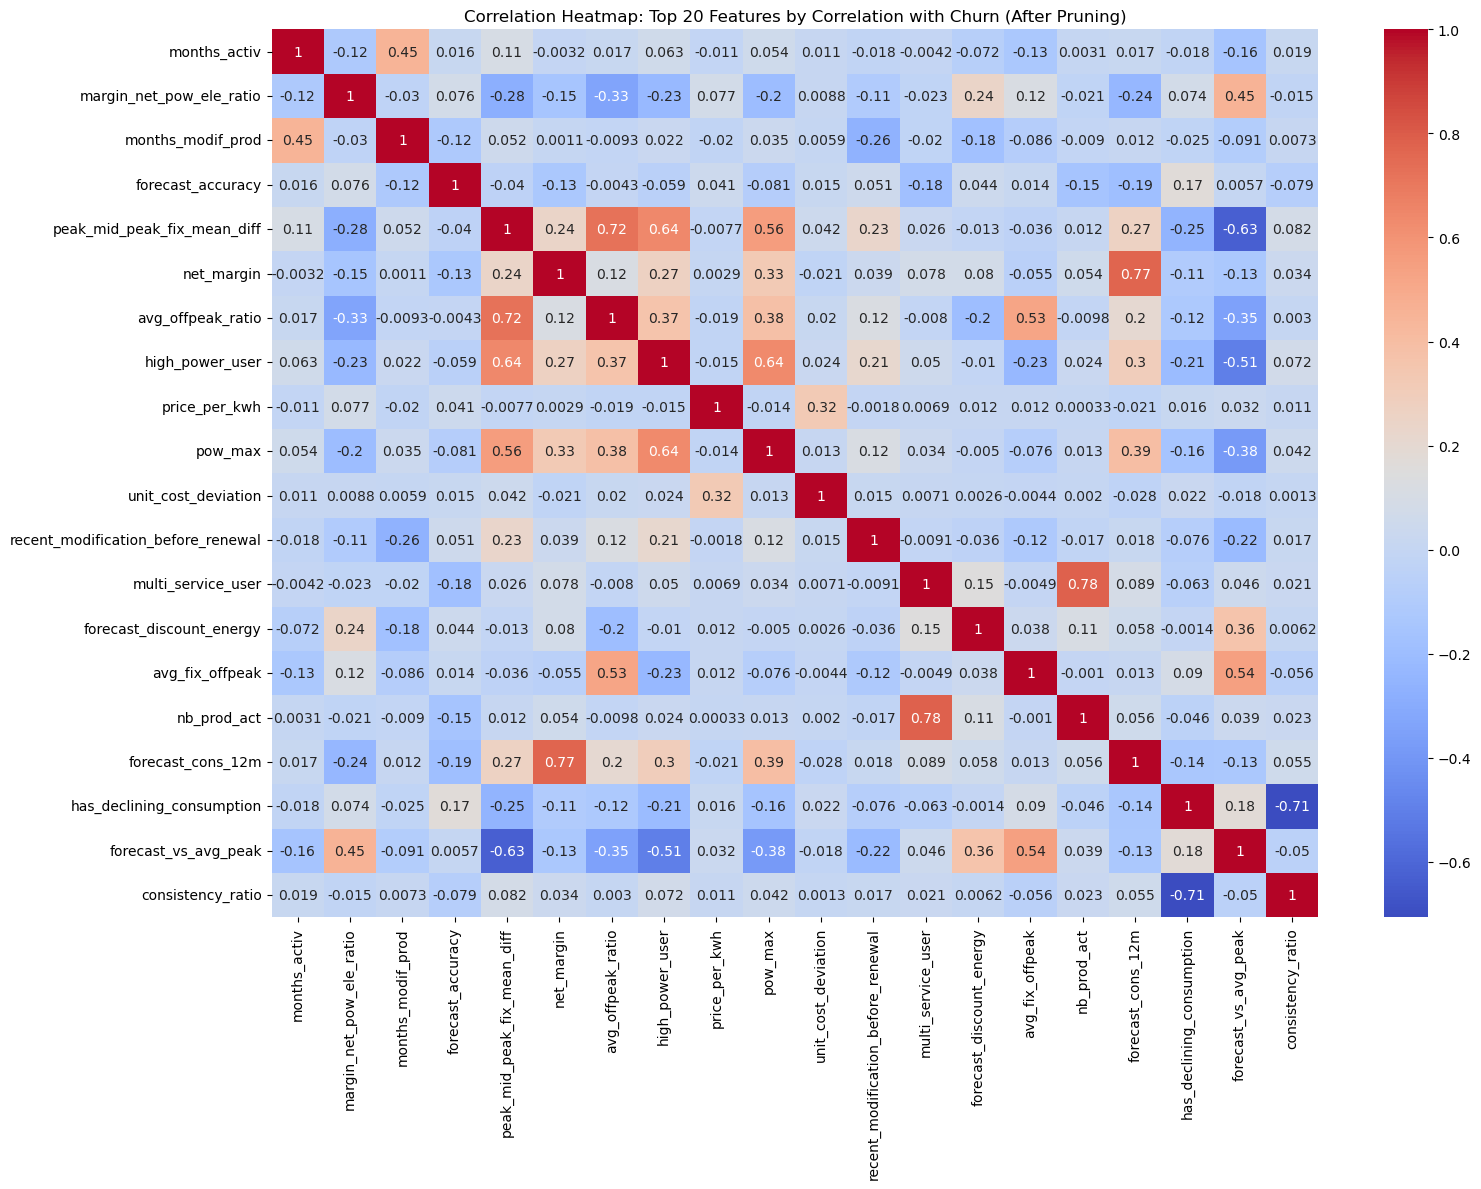

In [123]:
# List of features to drop
features_to_drop = [
    'margin_net_pow_ele', 'margin_gross_pow_ele', 'date_activ_year', 'avg_peak_volatility', 'avg_fix_peak',
    'avg_fix_midpeak', 'avg_monthly_consumption', 'cons_last_month', 'cons_12m', 'date_modif_prod_year',
    'days_since_product_changed', 'num_years_antig', 'cons_gas_12m', 'avg_var_peak', 'has_gas',
    'forecast_price_energy_peak', 'forecast_vs_actual_margin', 'forecast_price_pow_off_peak',
    'tenure_days', 'modification_to_renewal_days', 'avg_var_midpeak', 'off_peak_mid_peak_var_mean_diff',
    'off_peak_mid_peak_fix_mean_diff','forecast_meter_rent_12m','off_peak_peak_fix_mean_diff',
    'peak_mid_peak_fix_diff', 'off_peak_peak_var_mean_diff','forecast_price_energy_off_peak'
]

# Remove them from the cols list
cols = [col for col in cols if col not in features_to_drop]

# Now re-run the correlation heatmap for the updated cols
corr_with_target = client_price_df[cols + ['churn']].corr(numeric_only=True)['churn']
top20 = corr_with_target.abs().sort_values(ascending=False).index[1:21]  # skip 'churn' itself

plt.figure(figsize=(16, 12))
sns.heatmap(client_price_df[top20].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap: Top 20 Features by Correlation with Churn (After Pruning)")
plt.tight_layout()
plt.show()

In [124]:
for col in cols:
    if col not in features_to_drop:
        corr = client_price_df[col].corr(client_price_df['churn'])
        print(f"\nFeature: {col}")
        print(f"Correlation with churn: {corr:.4f}")
        display(client_price_df.groupby('churn')[col].describe())


Feature: margin_net_pow_ele_ratio
Correlation with churn: 0.0718


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,1.488194,1.026743,0.0,0.917692,1.457005,2.038531,15.009091
1,1419.0,1.744907,1.302892,0.0,1.061320,1.650000,2.284477,15.009091



Feature: forecast_accuracy
Correlation with churn: 0.0461


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,-166008.793218,596352.763049,-6207018.99,-37526.955,-12589.45,-4937.475,3534.24
1,1419.0,-76899.616568,259875.124932,-3953109.41,-36987.755,-12800.61,-5205.805,1453.16



Feature: net_margin
Correlation with churn: 0.0411


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,185.057407,232.263231,0.0,50.510,111.86,239.855,10203.50
1,1419.0,228.361938,705.675542,0.0,52.605,121.86,271.935,24570.65



Feature: avg_offpeak_ratio
Correlation with churn: 0.0387


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,302.890130,46.488862,0.000,294.662780,299.849138,326.503502,586.184844
1,1419.0,308.915243,42.420007,188.411,295.879147,301.855281,327.294675,572.170862



Feature: high_power_user
Correlation with churn: 0.0375


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,0.244711,0.429932,0.0,0.0,0.0,0.0,1.0
1,1419.0,0.299507,0.458203,0.0,0.0,0.0,1.0,1.0



Feature: price_per_kwh
Correlation with churn: 0.0312


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,0.009971,0.017999,0.0,0.004324,0.010837,0.013091,1.666596
1,1419.0,0.016719,0.197765,0.0,0.005314,0.011227,0.013616,7.443333



Feature: pow_max
Correlation with churn: 0.0304


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,18.000339,13.154277,3.3,12.50,13.856,19.0,260.0
1,1419.0,19.387827,16.613367,6.0,13.15,13.856,19.8,320.0



Feature: unit_cost_deviation
Correlation with churn: 0.0301


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,0.000112,0.002029,0.0,0.0,0.0,0.000025,0.100015
1,1419.0,0.000357,0.004668,0.0,0.0,0.0,0.000036,0.100123



Feature: forecast_discount_energy
Correlation with churn: 0.0170


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,0.938197,5.037164,0.0,0.0,0.0,0.0,30.0
1,1419.0,1.231853,5.722344,0.0,0.0,0.0,0.0,30.0



Feature: avg_fix_offpeak
Correlation with churn: 0.0168


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,42.903812,4.675794,0.000000,40.688156,44.281745,44.370635,59.286190
1,1419.0,43.161941,3.152151,33.818552,40.674580,44.266930,44.370635,59.226745



Feature: nb_prod_act
Correlation with churn: -0.0149


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,1.295822,0.720915,1.0,1.0,1.0,1.0,32.0
1,1419.0,1.260042,0.595614,1.0,1.0,1.0,1.0,5.0



Feature: forecast_cons_12m
Correlation with churn: 0.0129


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,1858.473333,2344.331993,0.0,494.430,1108.55,2389.74,82902.83
1,1419.0,1962.861938,2756.320036,0.0,503.975,1152.35,2525.24,61357.17



Feature: has_declining_consumption
Correlation with churn: 0.0121


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,0.460226,0.498434,0.0,0.0,0.0,1.0,1.0
1,1419.0,0.480620,0.499800,0.0,0.0,0.0,1.0,1.0



Feature: consistency_ratio
Correlation with churn: -0.0089


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,0.922095,1.022641,0.0,0.0,0.870291,1.364464,15.315789
1,1419.0,0.891143,1.060451,0.0,0.0,0.832456,1.226672,11.094877



Feature: power_cost_ratio
Correlation with churn: -0.0079


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,1.863603,42.628365,0.0,0.071040,0.129956,0.264002,3464.1
1,1419.0,0.782165,8.710974,0.0,0.065903,0.128685,0.270316,285.0



Feature: forecast_vs_avg_peak
Correlation with churn: -0.0114


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,0.135811,0.026713,-0.101974,0.112587,0.142881,0.146348,0.306882
1,1419.0,0.134781,0.026580,0.066208,0.111931,0.140986,0.145711,0.325063



Feature: avg_var_offpeak
Correlation with churn: -0.0064


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,0.142375,0.022657,0.00000,0.124435,0.147711,0.150464,0.278098
1,1419.0,0.141887,0.021122,0.10314,0.124338,0.146732,0.149953,0.277738



Feature: offpeak_diff_dec_january_power
Correlation with churn: 0.0027


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,0.277313,1.317856,-44.266931,0.000004,0.162916,0.177779,40.728885
1,1419.0,0.289483,1.612365,-40.565969,0.000004,0.162916,0.177779,15.177779



Feature: days_until_renewal
Correlation with churn: -0.0062


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,-132.468416,118.573418,-888.0,-226.0,-127.0,-33.0,58.0
1,1419.0,-134.945032,116.908478,-764.0,-233.0,-138.0,-33.0,58.0



Feature: days_until_contract_end
Correlation with churn: 0.0018


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,372.543414,54.158561,234.0,363.0,365.0,365.0,1212.0
1,1419.0,372.878788,51.644338,344.0,363.0,365.0,365.0,1063.0



Feature: recent_modification_before_renewal
Correlation with churn: 0.0251


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,0.061727,0.240669,0.0,0.0,0.0,0.0,1.0
1,1419.0,0.082452,0.275150,0.0,0.0,0.0,0.0,1.0



Feature: multi_service_user
Correlation with churn: -0.0171


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,0.219686,0.414050,0.0,0.0,0.0,0.0,1.0
1,1419.0,0.195913,0.397042,0.0,0.0,0.0,0.0,1.0



Feature: forecast_cons_year
Correlation with churn: -0.0026


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,1402.487601,3302.114000,0.0,0.0,312.0,1750.5,175375.0
1,1419.0,1374.441860,2691.815516,0.0,0.0,326.0,1688.5,37891.0



Feature: imp_cons
Correlation with churn: -0.0016


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,152.964184,346.405416,0.0,0.0,36.67,194.350,15042.79
1,1419.0,151.139331,290.522837,0.0,0.0,41.40,187.755,4205.64



Feature: offpeak_diff_dec_january_energy
Correlation with churn: -0.0011


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,-0.004561,0.011787,-0.148477,-0.007829,-0.005310,-0.003423,0.168958
1,1419.0,-0.004605,0.014256,-0.138871,-0.008161,-0.006192,-0.003767,0.145627



Feature: peak_mid_peak_var_mean_diff
Correlation with churn: -0.0066


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,0.023850,0.029089,0.0,0.0,0.028768,0.030364,0.196275
1,1419.0,0.023207,0.026529,0.0,0.0,0.029112,0.030377,0.167235



Feature: peak_mid_peak_fix_mean_diff
Correlation with churn: 0.0459


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,3.290713,4.769668,0.0,0.0,0.0,8.121339,28.122958
1,1419.0,4.036767,5.181951,0.0,0.0,0.0,8.126769,28.122958



Feature: months_activ
Correlation with churn: -0.0748


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,57.002427,19.046416,14.0,42.0,56.0,69.0,148.0
1,1419.0,52.201550,18.105714,24.0,39.0,47.0,65.0,146.0



Feature: months_to_end
Correlation with churn: -0.0049


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,7.266475,3.443148,1.0,4.0,7.0,10.0,18.0
1,1419.0,7.209302,3.501847,1.0,4.0,7.0,10.0,13.0



Feature: months_modif_prod
Correlation with churn: -0.0521


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,34.331918,29.908433,-1.0,5.0,30.0,63.0,148.0
1,1419.0,29.104299,27.408066,-1.0,5.0,23.0,48.5,146.0



Feature: months_renewal
Correlation with churn: 0.0070


,count,mean,std,min,25%,50%,75%,max
churn,,,,,,,,
0,13187.0,3.912641,3.645581,-1.0,1.0,4.0,7.0,28.0
1,1419.0,3.998591,3.579837,-1.0,1.0,4.0,7.0,24.0


🔑 **Key Observations**

---

💥 **High Redundancy (Multicollinearity)**

- `avg_peak_volatility`, `avg_fix_peak`, `avg_var_midpeak` are _extremely_ correlated (near **1.00**).
    - 🧠 These  capture the same underlying signal (e.g., price levels or variation across similar periods).
    - 👉 **Action:** We don’t need all—pick one or drop two.

---

💸 **Strong Collinearity in Margins**

- `margin_net_pow_ele`, `margin_gross_pow_ele`, `margin_net_pow_ele_ratio` are highly correlated (**r = 0.67–1.00**).
    - 🧠 All are margin-based, likely reflecting the same pricing-pressure signal.
    - 👉 **Action:** Including all three could confuse models and dilute interpretability. Choose one raw metric or the normalized ratio.

---

⏳ **Temporal Redundancy**

- `date_activ_year` and `num_years_antig` are strongly negatively correlated (**r = –0.95**)—essentially inverted versions of each other.
    - 🧠 `num_years_antig` is clearer and easier to interpret.
    - 👉 **Action:** Keep only one.

---

✅ **Next Steps**

- ✂️ **Prune highly redundant features. Keep:**
    - `margin_net_pow_ele_ratio` (_drop gross and net separately_)
    - `num_years_antig` (_drop date_activ_year_)
    - `avg_peak_volatility` (_drop avg_var_midpeak and avg_fix_peak_)

---


### **Prune Features**

In [125]:
# Always keep these important columns
extra_features = ['channel_sales', 'origin_up', 'churn']

# Create the final list of features to keep
safe_features = [feature for feature in cols if feature not in features_to_drop] + extra_features

# Remove duplicates in case any are already present
safe_features = list(dict.fromkeys(safe_features))

# Update client_price_df to keep only safe features
client_price_df = client_price_df[safe_features]

# Print result to verify
print(f"Final feature count: {len(safe_features)}")
print(client_price_df.head())


Final feature count: 34
   margin_net_pow_ele_ratio  forecast_accuracy  net_margin  avg_offpeak_ratio  \
0                  0.582845               0.00      678.99         328.096982   
1                  1.186957           -4470.05       18.89         296.181379   
2                  2.064088            -496.04        6.60         260.307410   
3                  2.289394           -1343.96       25.46         293.632966   
4                  2.268182           -3979.25       47.98         327.669616   

   high_power_user  price_per_kwh  pow_max  unit_cost_deviation  \
0                1       0.000000   43.648              0.00000   
1                0       0.004054   13.800              0.00000   
2                0       0.012132   13.856              0.00000   
3                0       0.016073   13.200              0.00000   
4                1       0.010843   19.800              0.00019   

   forecast_discount_energy  avg_fix_offpeak  ...  \
0                       0.0      

# **Save the Dataset**

In [126]:
# Save the final DataFrame to a CSV file
client_price_df.to_csv('D:/LHL/repo2/PowerCo-Custumer-Churn/PowerCo-Custumer-Churn/Data/engineered_df.csv', index=False)
print("Final DataFrame saved to engineered_df.csv")

Final DataFrame saved to engineered_df.csv
